# Parte 1: más CNN en CIFAR10
- Tome el ejemplo disponible en el sitio del curso y juegue con los hiperparámetros y estructura de la red hasta obtener el rendimiento más alta en el set de validación/test.
- A continuación, explore el uso de aumento de datos
(https://www.tensorflow.org/tutorials/images/data_augmentation) y compare el efecto que este tiene sobre los resultados utilizando la arquitectura original, en comparación a los obtenidos en el ítem anterior.
- Combine ambos esquemas, es decir, aumento de datos y búsqueda de mejor arquitectura, y comente si es posible obtener mejor resultados que los anteriores.

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import TensorFlow

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier


import matplotlib.pyplot as plt

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 12})

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


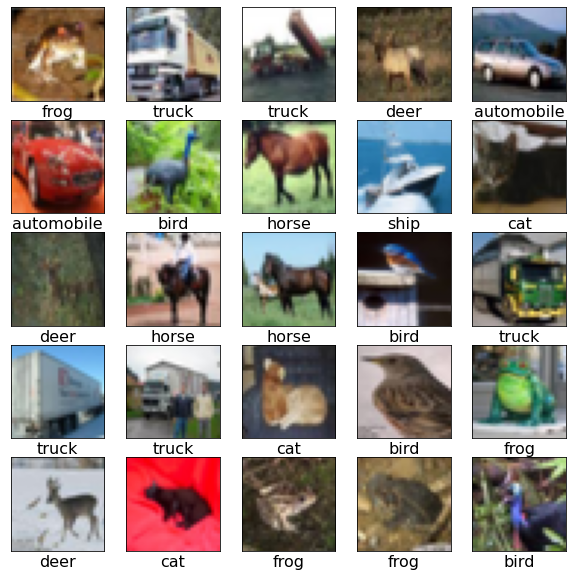

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Entrenamiento de Modelo Base

In [ ]:
base_model = models.Sequential(
        [
            layers.InputLayer(input_shape=(32, 32, 3)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(10, activation="softmax"),
        ]
    )
base_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
base_history = base_model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
352/352 [==============================] - 4s 11ms/step - loss: 1.6356 - accuracy: 0.4094 - val_loss: 1.3264 - val_accuracy: 0.5388
Epoch 2/20
352/352 [==============================] - 3s 9ms/step - loss: 1.2933 - accuracy: 0.5440 - val_loss: 1.1828 - val_accuracy: 0.5920
Epoch 3/20
352/352 [==============================] - 4s 10ms/step - loss: 1.1670 - accuracy: 0.5926 - val_loss: 1.0613 - val_accuracy: 0.6368
Epoch 4/20
352/352 [==============================] - 3s 9ms/step - loss: 1.0971 - accuracy: 0.6180 - val_loss: 1.0148 - val_accuracy: 0.6532
Epoch 5/20
352/352 [==============================] - 3s 9ms/step - loss: 1.0379 - accuracy: 0.6390 - val_loss: 0.9472 - val_accuracy: 0.6744
Epoch 6/20
352/352 [==============================] - 3s 9ms/step - loss: 1.0010 - accuracy: 0.6538 - val_loss: 0.9224 - val_accuracy: 0.6850
Epoch 7/20
352/352 [==============================] - 4s 10ms/step - loss: 0.9720 - accuracy: 0.6651 - val_loss: 0.9304 - val_accuracy: 0.6856
Epo

313/313 - 1s - loss: 0.7794 - accuracy: 0.7344 - 931ms/epoch - 3ms/step


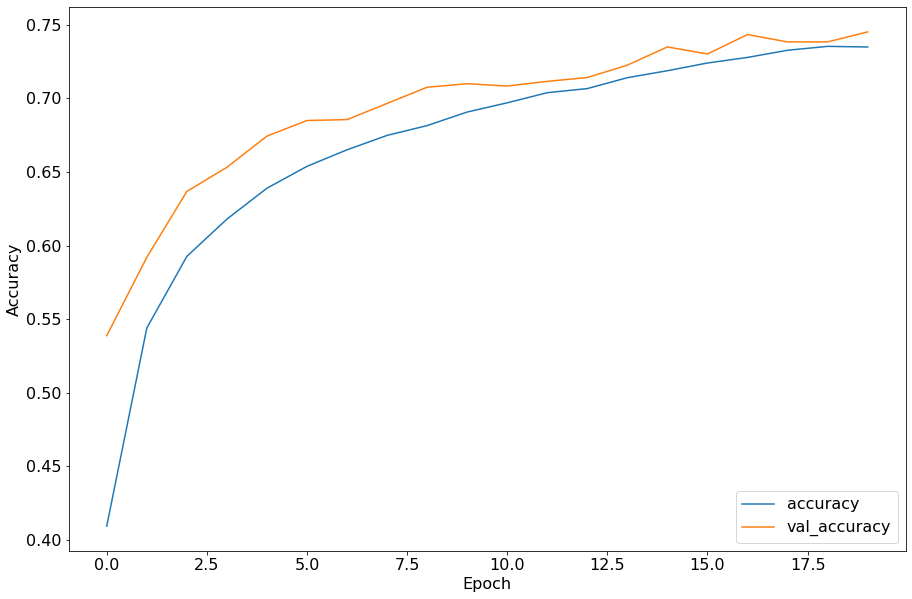

In [ ]:
plt.plot(base_history.history['accuracy'], label='accuracy')
plt.plot(base_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
base_model_test_loss, base_model_test_acc = base_model.evaluate(test_images,  test_labels, verbose=2)
print("Base Model Test Accuracy:", base_model_test_acc)

313/313 - 1s - loss: 0.7794 - accuracy: 0.7344 - 1s/epoch - 4ms/step
Base Model Test Accuracy: 0.7343999743461609


Building the models (MLP and CNN)

# Grid Search de hiperparametros

In [ ]:
def create_model(activation, dropout_rate, kernel_size):
    CNN = models.Sequential(
        [
            layers.InputLayer(input_shape=(32, 32, 3)),
            layers.Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=activation),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(kernel_size, kernel_size), activation=activation),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )
    CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return CNN

Model training

In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
model = KerasClassifier(model=create_model, epochs=20, batch_size=128)

In [ ]:
param_grid = {
    "model__activation": ["relu", "sigmoid"],
    "model__dropout_rate": [.4, .6],
    "model__kernel_size": [3, 5]
}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=4)
grid_result = grid.fit(train_images, train_labels)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20
261/261 [==============================] - 10s 9ms/step - loss: 1.7134 - accuracy: 0.3843
Epoch 2/20
261/261 [==============================] - 2s 9ms/step - loss: 1.3642 - accuracy: 0.5160
Epoch 3/20
261/261 [==============================] - 2s 8ms/step - loss: 1.2408 - accuracy: 0.5650
Epoch 4/20
261/261 [==============================] - 2s 8ms/step - loss: 1.1548 - accuracy: 0.5995
Epoch 5/20
261/261 [==============================] - 2s 8ms/step - loss: 1.0793 - accuracy: 0.6242
Epoch 6/20
261/261 [==============================] - 2s 8ms/step - loss: 1.0334 - accuracy: 0.6429
Epoch 7/20
261/261 [==============================] - 2s 8ms/step - loss: 0.9936 - accuracy: 0.6555
Epoch 8/20
261/261 [==============================] - 2s 8ms/step - loss: 0.9567 - accuracy: 0.6673
Epoch 9/20
261/261 [==============================] - 2s 8ms/step - loss: 0.9281 - accuracy: 0.6787
Epoch 10/20
261/261 [==================

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f +/- %f with: %r" % (mean, stdev, param))

Best: 0.722220 using {'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__kernel_size': 5}
0.715720 +/- 0.003476 with: {'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__kernel_size': 3}
0.722220 +/- 0.003673 with: {'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__kernel_size': 5}
0.717360 +/- 0.004302 with: {'model__activation': 'relu', 'model__dropout_rate': 0.6, 'model__kernel_size': 3}
0.711720 +/- 0.003623 with: {'model__activation': 'relu', 'model__dropout_rate': 0.6, 'model__kernel_size': 5}
0.533600 +/- 0.003238 with: {'model__activation': 'sigmoid', 'model__dropout_rate': 0.4, 'model__kernel_size': 3}
0.597360 +/- 0.001893 with: {'model__activation': 'sigmoid', 'model__dropout_rate': 0.4, 'model__kernel_size': 5}
0.518800 +/- 0.003678 with: {'model__activation': 'sigmoid', 'model__dropout_rate': 0.6, 'model__kernel_size': 3}
0.572520 +/- 0.003950 with: {'model__activation': 'sigmoid', 'model__dropout_rate': 0.6, 'model__kernel_size':

In [ ]:
gs_model_test_loss, gs_model_test_acc = grid.best_estimator_.model_.evaluate(test_images, test_labels)
print("Base Model Test Accuracy:", gs_model_test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.7611 - accuracy: 0.7471
Base Model Test Accuracy: 0.7470999956130981


# Data Augmentation

In [ ]:
layers.RandomFlip("horizontal")(train_images[i]).shape

TensorShape([32, 32, 3])

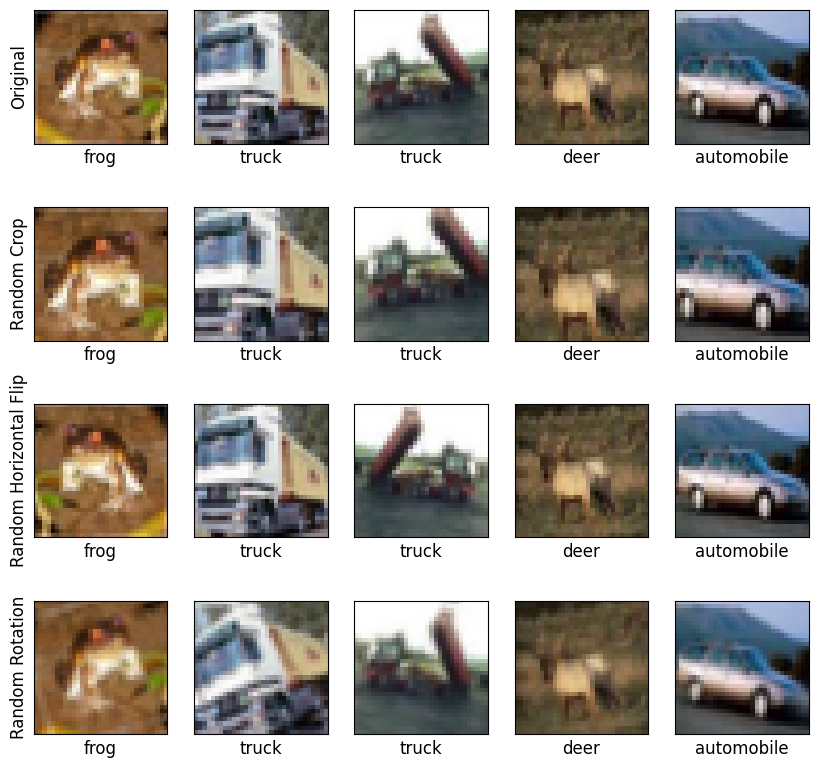

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
for i in range(5):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    if i == 0:
        plt.ylabel("Original")

for i in range(5):
    plt.subplot(4, 5, 5 + i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(layers.RandomCrop(28, 28)(train_images[i], training=True), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    if i == 0:
        plt.ylabel("Random Crop")

for i in range(5):
    plt.subplot(4, 5, 10 + i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(layers.RandomFlip("horizontal")(train_images[i], training=True), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    if i == 0:
        plt.ylabel("Random Horizontal Flip")

for i in range(5):
    plt.subplot(4, 5, 15 + i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(layers.RandomRotation(.1)(train_images[i], training=True), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    if i == 0:
        plt.ylabel("Random Rotation")

plt.ylabel
plt.show()

In [ ]:
da_model = models.Sequential(
        [
            layers.InputLayer(input_shape=(32, 32, 3)),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomCrop(30, 30),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(10, activation="softmax"),
        ]
    )
da_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
da_history = da_model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
352/352 [==============================] - 45s 13ms/step - loss: 1.7201 - accuracy: 0.3785 - val_loss: 1.4006 - val_accuracy: 0.5062
Epoch 2/20
352/352 [==============================] - 4s 12ms/step - loss: 1.4743 - accuracy: 0.4757 - val_loss: 1.2629 - val_accuracy: 0.5628
Epoch 3/20
352/352 [==============================] - 3s 10ms/step - loss: 1.3781 - accuracy: 0.5118 - val_loss: 1.2129 - val_accuracy: 0.5792
Epoch 4/20
352/352 [==============================] - 4s 10ms/step - loss: 1.3181 - accuracy: 0.5325 - val_loss: 1.1989 - val_accuracy: 0.5856
Epoch 5/20
352/352 [==============================] - 3s 10ms/step - loss: 1.2826 - accuracy: 0.5478 - val_loss: 1.1031 - val_accuracy: 0.6172
Epoch 6/20
352/352 [==============================] - 4s 10ms/step - loss: 1.2507 - accuracy: 0.5599 - val_loss: 1.0780 - val_accuracy: 0.6310
Epoch 7/20
352/352 [==============================] - 4s 10ms/step - loss: 1.2265 - accuracy: 0.5679 - val_loss: 1.0454 - val_accuracy: 0.646

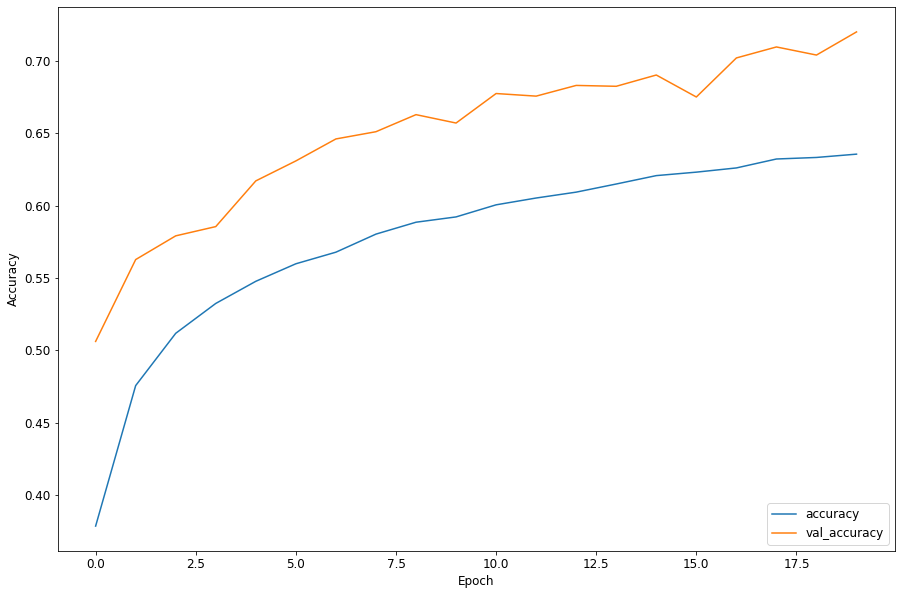

In [ ]:
plt.plot(da_history.history['accuracy'], label='accuracy')
plt.plot(da_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
da_model_test_loss, da_model_test_acc = da_model.evaluate(test_images,  test_labels, verbose=2)
print("Base Model Test Accuracy:", da_model_test_acc)

313/313 - 1s - loss: 0.8623 - accuracy: 0.7082 - 988ms/epoch - 3ms/step
Base Model Test Accuracy: 0.7081999778747559


# Data Augmentation y Grid Search

In [ ]:
def create_da_model(activation, dropout_rate, kernel_size):
    CNN = models.Sequential(
        [
            layers.InputLayer(input_shape=(32, 32, 3)),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomCrop(30, 30),
            layers.Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=activation),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(kernel_size, kernel_size), activation=activation),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )
    CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return CNN

In [ ]:
da_model_wrapper = KerasClassifier(model=create_da_model, epochs=20, batch_size=128)

In [ ]:
da_grid = GridSearchCV(estimator=da_model_wrapper, param_grid=param_grid, cv=3, verbose=4)
da_grid_result = da_grid.fit(train_images, train_labels)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20
261/261 [==============================] - 3s 10ms/step - loss: 1.7627 - accuracy: 0.3638
Epoch 2/20
261/261 [==============================] - 2s 9ms/step - loss: 1.4988 - accuracy: 0.4644
Epoch 3/20
261/261 [==============================] - 2s 9ms/step - loss: 1.4031 - accuracy: 0.5064
Epoch 4/20
261/261 [==============================] - 2s 9ms/step - loss: 1.3450 - accuracy: 0.5254
Epoch 5/20
261/261 [==============================] - 2s 10ms/step - loss: 1.2996 - accuracy: 0.5411
Epoch 6/20
261/261 [==============================] - 2s 9ms/step - loss: 1.2669 - accuracy: 0.5561
Epoch 7/20
261/261 [==============================] - 2s 9ms/step - loss: 1.2353 - accuracy: 0.5663
Epoch 8/20
261/261 [==============================] - 2s 9ms/step - loss: 1.2194 - accuracy: 0.5740
Epoch 9/20
261/261 [==============================] - 2s 9ms/step - loss: 1.1850 - accuracy: 0.5850
Epoch 10/20
261/261 [=================

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f +/- %f with: %r" % (mean, stdev, param))

In [ ]:
gs_model_test_loss, gs_model_test_acc = grid.best_estimator_.model_.evaluate(test_images, test_labels)
print("Base Model Test Accuracy:", gs_model_test_acc)

## Referencias
- How to Grid Search Hyperparameters for Deep Learning Models in Python with Keras. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Parte 2: estimación de edad
- Descargue el set de datos UTKFace del sitio del curso y revise las especificaciones de este en https://susanqq.github.io/UTKFace/.
- Cargue el set de datos y grafique la distribución de las edades.
- Construya una CNN que a partir de una regresión, permita estimar la edad de las personas en la fotografías. Calcule métricas de rendimiento relevantes.
- Analice el efecto del desbalance de las edades y proponga un esquema para enfrentarlo, si ahora el problema de estimación se plantea como una clasificación.

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gdown
import shutil
import os
from PIL import Image
import numpy as np
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

In [ ]:
gdown.download_folder("https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?resourcekey=0-01Pth1hq20K4kuGVkp3oBw", quiet=True, output="data")

['data/crop_part1.tar.gz', 'data/UTKFace.tar.gz']

In [ ]:
shutil.unpack_archive("data/UTKFace.tar.gz", "data/UTKFace")

In [ ]:
filenames = os.listdir("data/UTKFace/UTKFace")
for filename in filenames:
    name, *extensions = filename.split(".")
    os.rename(f"data/UTKFace/UTKFace/{filename}", f"data/UTKFace/UTKFace/{name}.jpg")
filenames = os.listdir("data/UTKFace/UTKFace")

In [ ]:
ages = np.array([int(filename.split("_")[0]) for filename in filenames])

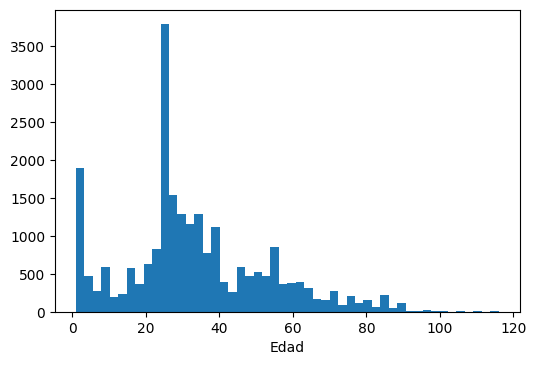

In [ ]:
plt.figure(dpi=100)
plt.hist(ages, bins=50)
plt.xlabel("Edad")
plt.show()

### Construcción del dataset

In [ ]:
train_indices = np.random.choice(np.arange(len(filenames)), int(.8*len(filenames)), replace=False)
train_mask = np.zeros(len(filenames), dtype=bool)
train_mask[train_indices] = True

test_mask = ~train_mask

In [ ]:
images = np.array([np.asarray(Image.open(f'data/UTKFace/UTKFace/{filename}')) for filename in filenames])

train_images, train_ages = images[train_mask], ages[train_mask]
test_images, test_ages = images[test_mask], ages[test_mask]

# Borramos la lista de imagenes iniciales y hacemos que el garbage collector libere la memoria
# para evitar tener problemas de memoria mas adelante
del images
gc.collect()

5800

In [ ]:
train_ages = np.log(train_ages)
test_ages = np.log(test_ages)

In [ ]:
CNN = models.Sequential(
        [
            layers.InputLayer(input_shape=(200, 200, 3)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(.5),
            layers.Dense(1),
        ]
    )
CNN.compile(loss="mean_squared_error", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = CNN.fit(train_images, train_ages, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
134/134 [==============================] - 53s 287ms/step - loss: 6989.3179 - root_mean_squared_error: 83.6021 - val_loss: 2.0498 - val_root_mean_squared_error: 1.4317
Epoch 2/20
134/134 [==============================] - 35s 265ms/step - loss: 4.6175 - root_mean_squared_error: 2.1488 - val_loss: 4.8473 - val_root_mean_squared_error: 2.2016
Epoch 3/20
134/134 [==============================] - 35s 264ms/step - loss: 5.3251 - root_mean_squared_error: 2.3076 - val_loss: 11.1001 - val_root_mean_squared_error: 3.3317
Epoch 4/20
134/134 [==============================] - 35s 263ms/step - loss: 59.1582 - root_mean_squared_error: 7.6914 - val_loss: 3.9643 - val_root_mean_squared_error: 1.9910
Epoch 5/20
134/134 [==============================] - 35s 263ms/step - loss: 2.7390 - root_mean_squared_error: 1.6550 - val_loss: 1.5473 - val_root_mean_squared_error: 1.2439
Epoch 6/20
134/134 [==============================] - 35s 263ms/step - loss: 1.4912 - root_mean_squared_error: 1.2212 -

### Esquema de Clasificación

In [ ]:
unique_ages, counts = np.unique(ages, return_counts=True)

In [ ]:
classes = []
class_ = []
class_count = 0
for age, c in zip(unique_ages, counts):
    if class_count >= 1000:
        classes.append((class_, class_count))
        class_ = []
        class_count = 0

    class_count += c
    class_.append(age)

In [ ]:
classes

[([1], 1123),
 ([2, 3, 4], 1044),
 ([5, 6, 7, 8, 9, 10], 1051),
 ([11, 12, 13, 14, 15, 16, 17], 1015),
 ([18, 19, 20, 21, 22], 1385),
 ([23, 24], 1285),
 ([25, 26], 2931),
 ([27, 28], 1533),
 ([29, 30], 1294),
 ([31, 32], 1014),
 ([33, 34, 35], 1432),
 ([36, 37, 38], 1101),
 ([39, 40, 41, 42], 1190),
 ([43, 44, 45, 46, 47], 1020),
 ([48, 49, 50, 51, 52], 1052),
 ([53, 54, 55, 56], 1098),
 ([57, 58, 59, 60, 61, 62], 1029),
 ([63, 64, 65, 66, 67, 68, 69, 70, 71, 72], 1017),
 ([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
  1007)]

In [ ]:
class_labels = np.zeros_like(ages)
for i, age in enumerate(ages):
    for j, (cls, c) in enumerate(classes):
        if age in cls:
            class_labels[i] = j

In [ ]:
class_label_names = ["/".join(map(str, cls)) for cls, c in classes]

In [ ]:
images = np.array([np.asarray(Image.open(f'data/UTKFace/UTKFace/{filename}')) for filename in filenames])

train_images, train_labels = images[train_mask], class_labels[train_mask]
test_images, test_labels = images[test_mask], class_labels[test_mask]

del images
gc.collect()

5837

In [ ]:
CNN_classifier = models.Sequential(
        [
            layers.InputLayer(input_shape=(200, 200, 3)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(.5),
            layers.Dense(len(classes), activation="softmax"),
        ]
    )
CNN_classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
classifier_history = CNN_classifier.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
134/134 [==============================] - 50s 353ms/step - loss: 3.7689 - accuracy: 0.1053 - val_loss: 2.9323 - val_accuracy: 0.1239
Epoch 2/20
134/134 [==============================] - 45s 337ms/step - loss: 2.9300 - accuracy: 0.1172 - val_loss: 2.9214 - val_accuracy: 0.1255
Epoch 3/20
134/134 [==============================] - 45s 337ms/step - loss: 2.9192 - accuracy: 0.1208 - val_loss: 2.9103 - val_accuracy: 0.1176
Epoch 4/20
134/134 [==============================] - 45s 338ms/step - loss: 2.9118 - accuracy: 0.1195 - val_loss: 2.8981 - val_accuracy: 0.1218
Epoch 5/20
134/134 [==============================] - 45s 337ms/step - loss: 2.9150 - accuracy: 0.1194 - val_loss: 2.9033 - val_accuracy: 0.1255
Epoch 6/20
134/134 [==============================] - 45s 336ms/step - loss: 2.9060 - accuracy: 0.1209 - val_loss: 2.9001 - val_accuracy: 0.1255
Epoch 7/20
134/134 [==============================] - 45s 336ms/step - loss: 2.9040 - accuracy: 0.1211 - val_loss: 2.8981 - val_ac